# E-MOSAIC

引用自[E. R. Q. Fernandes, A. C. P. L. F. de Carvalho and X. Yao, "Ensemble of Classifiers Based on Multiobjective Genetic Sampling for Imbalanced Data," in IEEE Transactions on Knowledge and Data Engineering, vol. 32, no. 6, pp. 1104-1115, 1 June 2020, doi: 10.1109/TKDE.2019.2898861.]


## 数据集的预处理 

In [1]:
from sklearn.preprocessing import StandardScaler
import numpy as np
from utils.dataset_utils import get_classes_indexes_counts, balanced_dataset
import scipy.io as sio  # 从.mat文件中读取数据集
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.neural_network import MLPClassifier

# 随机种子
random_seed = 42
print("#########################加载数据集#########################")
# 数据集
# Nursery(20、100、0.1)、Satellite(15、100、0.1)、Contraceptive(15、200、0.1)
datasetname = 'Satellite.mat'
mat_data = sio.loadmat('../../data/dataset/' + datasetname)

dataset_x = mat_data['X']
dataset_y = mat_data['Y'][:, 0]  # mat_data['Y']得到的形状为[n,1]，通过[:,0]，得到形状[n,]
# 显示数据集分布
print("特征数据:", dataset_x.shape, "label:", dataset_y.shape)
# 统计每个类别的个数
classes, counts = get_classes_indexes_counts(dataset_y)  #np.argmax(y_onehot, axis=1)找最大值的索引，将0-1序列转化为0,1,2,3......的整数标签
print("每种类别的分布：", counts)
print("#########################划分数据集#########################")
x_train, x_test, y_train, y_test = train_test_split(dataset_x, dataset_y, test_size=0.3, random_state=random_seed)

# 数据的标准化
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# 显示数据集分布
print("特征数据:", x_train.shape, "label:", y_train.shape)
# 统计每个类别的个数 
classes_train, counts_train = get_classes_indexes_counts(y_train)
# 计算每个类的权重
weights_train = (1 / counts_train.astype(float)) / np.sum(1 / counts_train.astype(float))
print("训练集每种类别的分布：", counts_train)
print("训练集每种类别的权重：", weights_train)

classes_test, counts_test = get_classes_indexes_counts(y_test)
print("测试集每种类别的分布：", counts_test)
print("#########################平衡数据集#########################")
# 确定每个类别的分布
num_instances = int(counts_train.min() * 1.0)  # 向下取整
num_instances_train = len(y_train)  # 取训练集的数量
print("最小数量:", num_instances)
# 在每个类别中随机的选择该数量的实例的索引
balanced_dataset_x, balanced_dataset_y = balanced_dataset(x_train, y_train, num_instances)
# 显示数据集分布
print("平衡的数据集的特征数据:", balanced_dataset_x.shape, "label:", balanced_dataset_y.shape)
# 统计每个类别的分布
classes_balanced_dataset, counts_balanced_dataset = get_classes_indexes_counts(balanced_dataset_y)
print("平衡的数据集中每种类别的分布：", counts_balanced_dataset)

######################计算三个目标值#########################
mlp_k_folds = MLPClassifier(hidden_layer_sizes=(15), max_iter=100, random_state=42, learning_rate_init=0.1)
# 3. 配置五折交叉验证
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. 使用 cross_val_predict 进行交叉验证并获取预测
y_pred_k_folds = cross_val_predict(mlp_k_folds, x_train, y_train, cv=cv)
cm_k_folds = confusion_matrix(y_train, y_pred_k_folds)
tp_per_class = cm_k_folds.diagonal()  # 对角线元素表示每个类预测正确的个数，对角线求和，即所有预测正确的实例个数之和，计算Acc1
s_per_class = cm_k_folds.sum(axis=1)
Acc1 = np.sum(tp_per_class) / np.sum(s_per_class)  # Acc1
Acc2 = np.mean(tp_per_class.astype(float) / s_per_class.astype(float))  # Acc2
Acc3 = np.mean((tp_per_class.astype(float) / s_per_class.astype(float)) * weights_train)  # Acc3
# 输出Acc1, Acc2, Acc3
print("Acc1:", round(Acc1, 4))
print("Acc2:", round(Acc2, 4))
print("Acc3:", round(Acc3, 4))

#########################加载数据集#########################
特征数据: (6435, 36) label: (6435,)
每种类别的分布： [1533  703 1358  626  707 1508]
#########################划分数据集#########################
特征数据: (4504, 36) label: (4504,)
训练集每种类别的分布： [1083  517  942  425  488 1049]
训练集每种类别的权重： [0.09955827 0.20855244 0.11446031 0.25369791 0.22094593 0.10278514]
测试集每种类别的分布： [450 186 416 201 219 459]
#########################平衡数据集#########################
最小数量: 425
平衡的数据集的特征数据: (2550, 36) label: (2550,)
平衡的数据集中每种类别的分布： [425 425 425 425 425 425]
Acc1: 0.8652
Acc2: 0.8259
Acc3: 0.1298


## NSGA-II

In [2]:
from instance_selection.multi_objective.genetic_operator import selNSGA2, mutate_binary_inversion, selTournamentDCD, \
    exponential_distribution, find_duplicates, remove_duplicates, fitness_function, get_feasible_infeasible, \
    init_by_one_or_zero, init_population_for_balanced_dataset
import warnings
from sklearn.neural_network import MLPClassifier
import array
import random
import matplotlib.pyplot as plt
from deap import base
from deap import creator
from deap import tools
from matplotlib.animation import FuncAnimation, PillowWriter

warnings.filterwarnings("ignore")  # 忽略警告
# 基本参数
x_init_train = x_train  # 特征数据初始化
y_init_train = y_train  # 标签初始化
NDIM = len(y_init_train)  # 个体基因长度
# lambda_ = 5.0  # 指数分布的参数λ（lambda）在下面的函数中，该值越大越偏向于1
# threshold = 1.0  # 阈值（阈值决定了生成0或1）
# 最大化评价目标
creator.create("FitnessMaxAndMax", base.Fitness, weights=(1.0, 1.0, 1.0))
creator.create("Individual", array.array, typecode='i', fitness=creator.FitnessMaxAndMax, pfc=None, mlp=None,
               y_sub_and_pred=None)
toolbox = base.Toolbox()
#toolbox.register("attr_binary", exponential_distribution, lambda_, threshold)  # 0-1编码
toolbox.register("attr_binary", init_by_one_or_zero, binary=0)  # 0-1编码，基因全部初始化为0或1
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_binary, n=NDIM)  # 个体初始化
toolbox.register("balanced_dataset_for_population", init_population_for_balanced_dataset, y_train=y_init_train,
                 ratio=0.9, show_details=True)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)  # 种群初始化
toolbox.register("evaluate", fitness_function, weights_train=weights_train)  # 评价函数
toolbox.register("mate", tools.cxOnePoint)  # 交叉
toolbox.register("mutate", mutate_binary_inversion)  # 二进制突变
#toolbox.register("select", selNSGA2, x_test=x_test, y_test=y_test)  # NSGA-II选择（非支配排序后）
toolbox.register("select", tools.selNSGA2)  # NSGA-II选择（非支配排序后）
toolbox.register("find_duplicates", find_duplicates)  # 找到种群中重复个体的索引对
toolbox.register("remove_duplicates", remove_duplicates)  # 去重
toolbox.register("get_feasible_infeasible", get_feasible_infeasible, Acc1=Acc1, Acc2=Acc2, Acc3=Acc3)  # 获取种群的可行解与不可行解

## 种群的迭代

gen	fronts	first_front_size	num_feasible	Gmean 	mAUC  
1  	13    	2               	1           	0.8618	0.9814
2  	11    	2               	3           	0.8618	0.9814
3  	11    	3               	6           	0.8618	0.9814
4  	10    	3               	6           	0.8618	0.9814
5  	11    	4               	8           	0.8618	0.9814
6  	11    	4               	9           	0.8618	0.9814
7  	12    	4               	10          	0.8618	0.9814
8  	12    	4               	10          	0.8618	0.9814
9  	12    	4               	10          	0.8618	0.9814
10 	12    	4               	11          	0.8618	0.9814
11 	11    	4               	12          	0.8618	0.9814
12 	11    	4               	14          	0.8618	0.9814
13 	12    	1               	16          	0.855 	0.9788
14 	11    	1               	18          	0.855 	0.9788
15 	11    	1               	19          	0.855 	0.9788
16 	11    	1               	20          	0.855 	0.9788
17 	11    	1               	21          	0.855 	0.9788
18 	11    

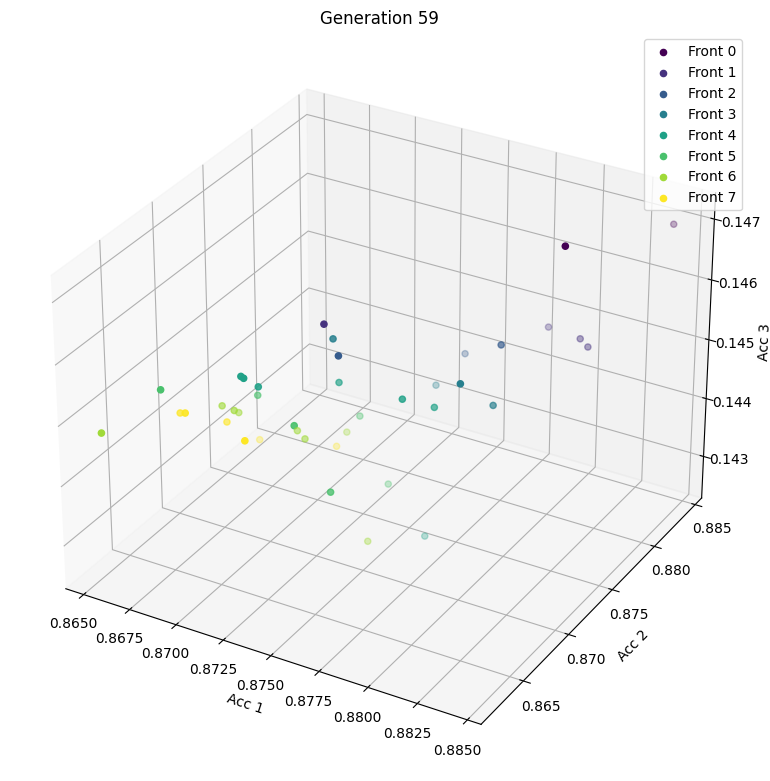

##############################集成分类器的预测结果：################################
Accuracy: 0.82
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       450
           1       0.99      0.91      0.95       186
           2       0.90      0.84      0.87       416
           3       0.51      0.74      0.61       201
           4       0.63      0.96      0.76       219
           5       0.93      0.60      0.73       459

    accuracy                           0.82      1931
   macro avg       0.82      0.84      0.81      1931
weighted avg       0.86      0.82      0.83      1931

Confusion Matrix:
[[435   0   4   0  11   0]
 [  1 170   0   3  12   0]
 [ 12   1 348  50   2   3]
 [  1   0  27 149   7  17]
 [  3   0   0   3 211   2]
 [  0   0   6  86  90 277]]
最终的集成分类结果：Recall_Per_Class['0.9667', '0.9140', '0.8365', '0.7413', '0.9635', '0.6035']，Gmean：0.8264，mAUC：0.9764


In [3]:
from instance_selection.multi_objective.genetic_operator import selTournamentNDCD
from instance_selection.multi_objective.ensemble_operator import vote_ensembles
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from utils.dataset_utils import get_subset

# 动画绘图函数
fig = plt.figure(figsize=(12.8, 9.6))
ax = fig.add_subplot(111, projection='3d')

pareto_fronts_history = []  # 动画中的数据


def update(frame):
    ax.clear()
    colors = plt.cm.viridis(np.linspace(0, 1, len(pareto_fronts_history[frame])))
    for i, front in enumerate(pareto_fronts_history[frame]):
        front_points = np.array([ind.fitness.values for ind in front])
        ax.scatter(front_points[:, 0], front_points[:, 1], front_points[:, 2], color=colors[i], label=f"Front {i}")
    ax.set_title(f"Generation {frame}")
    ax.set_xlabel("Acc 1")
    ax.set_ylabel("Acc 2")
    ax.set_zlabel("Acc 3")
    ax.legend()


def main(seed=None):
    random.seed(seed)
    NGEN = 60  # 迭代次数
    POPSIZE = 40  # 种群数量
    CXPB = 1.0  # 交叉因子/交叉率
    MR = 0.25  # 突变因子/突变率
    # MLP
    learning_rate = 0.1  # 学习率
    hidden_size = 15  # 隐含层神经元数量
    max_iter = 100  # 最大迭代次数（epoch）
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)  # 配置5-folds交叉验证

    # 计算适应度，同时会保存训练好的mlp模型
    def get_fitness_values(individual, seed):
        mlp = MLPClassifier(hidden_layer_sizes=(hidden_size,), max_iter=max_iter, random_state=seed,
                            learning_rate_init=learning_rate)
        x_sub, y_sub = get_subset(individual, x_init_train, y_init_train)
        # 使用 cross_val_predict 进行交叉验证并获取结果
        y_pred = cross_val_predict(mlp, x_sub, y_sub, cv=cv)
        # 用实例选择的子集训练模型
        mlp = MLPClassifier(hidden_layer_sizes=(hidden_size,), max_iter=max_iter, random_state=seed,
                            learning_rate_init=learning_rate)
        mlp.fit(x_sub, y_sub)
        individual.mlp = mlp
        individual.y_sub_and_pred = (y_sub, y_pred)
        # 由mlp模型得到个体的适应度
        individual.fitness.values = toolbox.evaluate(individual)

    ####################################迭代过程的记录#############################
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    logbook = tools.Logbook()
    # logbook.header = "gen", "fronts", "first_front_size", "ensemble_sign", "num_feasible", "Acc1", "Acc2", "Acc3", "recall_per_class", "Gmean", "mAUC"
    logbook.header = "gen", "fronts", "first_front_size", "num_feasible", "Gmean", "mAUC"
    ####################################种群的初始化###########################
    pop = toolbox.population(n=POPSIZE)
    pop = toolbox.balanced_dataset_for_population(pop) # 平衡种群中的个体
    ####################################计算初始种群的适应度###########################
    ensembles = []  # 用于集成当前每个个体对应的mlp模型
    # 对于每个个体都训练得到一个mlp模型，并计算个体的适应度
    for i in range(len(pop)):
        get_fitness_values(pop[i], random_seed + i)
    #################################非支配排序#########################################
    pop = toolbox.select(pop, len(pop))
    ####################################种群的迭代#################################################
    for gen in range(1, NGEN + 1):
        ensemble_sign = False
        # 选择、交叉、突变
        offspring = selTournamentNDCD(pop, POPSIZE, tournsize=3)  # 锦标赛选择（1、先根据非支配排序的等级2、再根据拥挤距离）
        # offspring = selTournamentDCD(pop, POPSIZE)  # 1、先根据非支配排序的等级2、再根据拥挤距离
        offspring = [toolbox.clone(ind) for ind in offspring]

        for i in range(0, len(offspring) - 1, 2):
            if random.random() <= CXPB:
                offspring[i], offspring[i + 1] = toolbox.mate(offspring[i], offspring[i + 1])  # 单点交叉

            offspring[i] = toolbox.mutate(offspring[i], MR)[0]  # 二进制反转突变
            offspring[i + 1] = toolbox.mutate(offspring[i + 1], MR)[0]  # 二进制反转突变
            del offspring[i].fitness.values, offspring[i + 1].fitness.values
        #############################################################合并、去重#####################################################
        pop = pop + offspring  # 种群的合并
        duplicates = toolbox.find_duplicates(pop)
        pop, num_duplicates = toolbox.remove_duplicates(pop, duplicates)  # 去重
        # 计算新种群适应度 
        for i in range(len(pop)):
            if not pop[i].fitness.valid:
                get_fitness_values(pop[i], random_seed + i)
        # 保证去重后的个体数大于等于种群数量
        while len(pop) < POPSIZE:
            add_individual = []
            num_add = POPSIZE - len(pop)
            for i in range(0, num_add):
                index = random.randint(0, len(offspring) - 1)  # 在0-len(offspring)范围内随机产生一个索引
                offspring[index] = toolbox.mutate(offspring[index], MR)[0]
                del offspring[index].fitness.values
                get_fitness_values(offspring[index], random_seed + i)
                add_individual.append(offspring[index])
            pop = pop + add_individual  # 种群的合并
            add_duplicates = toolbox.find_duplicates(pop)  # 找到重复个体的索引对
            pop, _ = toolbox.remove_duplicates(pop, add_duplicates)  # 去重
        ###############################################得到pareto_fronts############################################
        feasible_pop, infeasible_pop = toolbox.get_feasible_infeasible(pop)  # 得到可行解与不可行解
        if len(feasible_pop) >= POPSIZE:
            ensemble_sign = True
            pop = toolbox.select(feasible_pop, POPSIZE)
        else:
            pop = feasible_pop + infeasible_pop[:POPSIZE - len(feasible_pop)]  # 在不可行解中选取违约程度小的个体，保证pop数量为POPSIZE
            pop = toolbox.select(pop, POPSIZE)
        pareto_fronts = tools.sortNondominated(pop, POPSIZE)
        record = stats.compile(pop)
        # 对第一个等级里的mlp模型进行集成
        for ind in pareto_fronts[0]:
            ensembles.clear()
            ensembles.append(ind.mlp)
        ind_Acc1 = pareto_fronts[0][0].fitness.values[0]
        ind_Acc2 = pareto_fronts[0][0].fitness.values[1]
        ind_Acc3 = pareto_fronts[0][0].fitness.values[2]
        g_mean, m_auc, recall_per_class = vote_ensembles(ensembles, x_test, y_test)
        # logbook.record(gen=gen, fronts=len(pareto_fronts), first_front_size=len(pareto_fronts[0]),
        #                ensemble_sign=ensemble_sign, num_feasible=len(feasible_pop), Acc1=ind_Acc1, Acc2=ind_Acc2,
        #                Acc3=ind_Acc3,
        #                recall_per_class=recall_per_class, Gmean=g_mean, mAUC=m_auc, **record)
        logbook.record(gen=gen, fronts=len(pareto_fronts), first_front_size=len(pareto_fronts[0]),
                       num_feasible=len(feasible_pop), Gmean=g_mean, mAUC=m_auc, **record)
        print(logbook.stream)
        pareto_fronts_history.append(pareto_fronts)  # 记录每一代中不同等级的pareto front
    # 使用 FuncAnimation 生成动画
    savepath = "C:/Users/zsc/Desktop/"
    writer = PillowWriter(fps=5)  # 设置帧率
    anim = FuncAnimation(fig, update, frames=len(pareto_fronts_history), interval=200)
    anim.save(savepath + datasetname + "_pareto_front.gif", writer=writer)
    plt.show()
    return pop, stats, ensembles


if __name__ == "__main__":
    pop, stats, ensembles = main()
    print("##############################集成分类器的预测结果：################################")
    g_mean, m_auc, recall_per_class = vote_ensembles(ensembles, x_test, y_test, show_result=True)
    print(f"最终的集成分类结果：Recall_Per_Class{recall_per_class}，Gmean：{g_mean}，mAUC：{m_auc}")